# Goal of this notebook

We retrieve all files from https://github.com/ard-data/2020-rki-archive/tree/master/data/2_parsed, process them and combine them in one dataframe. For each date, we then aggregate the death counts for each German state and for Germany as a whole to get timeseries of cumulative deaths. In the end, we use this to also compute the incident deaths per day.

# Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
pd.set_option('display.max_columns', None) # display all columns
plt.rcParams["figure.figsize"] = (10, 6) # set size of plots

# Load one file

We can load a compressed .json-file from github like this:

In [3]:
df = pd.read_json('https://github.com/ard-data/2020-rki-archive/raw/master/data/2_parsed/data_2020-06-24-02-30.json.bz2', 
                 compression='bz2')

In [4]:
df.columns

Index(['IdBundesland', 'Bundesland', 'Landkreis', 'Altersgruppe', 'Geschlecht',
       'AnzahlFall', 'AnzahlTodesfall', 'ObjectId', 'Meldedatum',
       'IdLandkreis', 'Datenstand', 'NeuerFall', 'NeuerTodesfall', 'Refdatum',
       'NeuGenesen', 'AnzahlGenesen', 'IstErkrankungsbeginn', 'Altersgruppe2',
       'MeldedatumISO', 'DatenstandISO', 'RefdatumISO'],
      dtype='object')

In [5]:
df.head()

,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,ObjectId,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn,Altersgruppe2,MeldedatumISO,DatenstandISO,RefdatumISO
0,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,13826793,1584144000000,1001,"24.06.2020, 00:00 Uhr",0,-9,1584316800000,0,1,1,Nicht übermittelt,2020-03-14,2020-06-24,2020-03-16
1,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,13826794,1584576000000,1001,"24.06.2020, 00:00 Uhr",0,-9,1584057600000,0,1,1,Nicht übermittelt,2020-03-19,2020-06-24,2020-03-13
2,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,13826795,1584576000000,1001,"24.06.2020, 00:00 Uhr",0,-9,1584316800000,0,1,1,Nicht übermittelt,2020-03-19,2020-06-24,2020-03-16
3,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,13826796,1584748800000,1001,"24.06.2020, 00:00 Uhr",0,-9,1584057600000,0,1,1,Nicht übermittelt,2020-03-21,2020-06-24,2020-03-13
4,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,13826797,1585267200000,1001,"24.06.2020, 00:00 Uhr",0,-9,1584835200000,0,1,1,Nicht übermittelt,2020-03-27,2020-06-24,2020-03-22


# Load All Files

### Get filenames from repo

We first retrieve the filenames of all files listed in the repository:

In [6]:
import requests

user = "ard-data"
repo = "2020-rki-archive"

url = "https://api.github.com/repos/{}/{}/git/trees/master?recursive=1".format(user, repo)
r = requests.get(url)
res = r.json()

In [7]:
# the first 20 files found in the repo
for file in res["tree"][:20]:
    print(file["path"])

LICENSE
README.md
bin
bin/1_download.js
bin/2_deduplicate.sh
bin/3_parse.js
bin/cronjob.sh
bin/example_scan.js
bin/lib
bin/lib/config.js
bin/lib/helper.js
data
data/0_archived
data/0_archived/2020-03-27-12-00_dump.csv.bz2
data/0_archived/2020-03-28-12-00_dump.csv.bz2
data/0_archived/2020-03-30-12-00_dump.csv.bz2
data/0_archived/2020-03-31-01-37_dump.csv.bz2
data/0_archived/2020-04-01-21-19_dump.csv.bz2
data/0_archived/2020-04-02-11-08_dump.csv.bz2
data/0_archived/2020-04-03-04-47_dump.csv.bz2


We only keep those in the folder data/2_parsed

In [8]:
files_parsed = [file["path"] for file in res["tree"] if file["path"].startswith("data/2_parsed/")]

In [9]:
# the first 5 files in the folder data/2_parsed
files_parsed[:5]

['data/2_parsed/data_2020-03-27-12-00.json.bz2',
 'data/2_parsed/data_2020-03-28-12-00.json.bz2',
 'data/2_parsed/data_2020-03-30-12-00.json.bz2',
 'data/2_parsed/data_2020-03-31-01-37.json.bz2',
 'data/2_parsed/data_2020-04-01-21-19.json.bz2']

### Retrieve all files from data/2_parsed and combine into one dataframe

In [10]:
# read in all files
dfs = []
for filename in files_parsed:
    df = pd.read_json('https://github.com/ard-data/2020-rki-archive/raw/master/' + filename, compression='bz2')
    dfs.append(df)

In [11]:
# number of files
len(dfs)

89

In [12]:
# combine all files
df = pd.concat(dfs)

# Cleaning

Sometimes the column DatenstandISO is missing (2020-04-19, 2020-05-19, 2020-06-19)

In [13]:
# there are missing entries in column 'DatenstandISO'
df.DatenstandISO.isnull().sum()

397024

In [14]:
# for each value in 'Datenstand' we check the corresponding entry in 'DatenstandISO'
temp = df.groupby('Datenstand')['DatenstandISO'].first()

In [15]:
temp.head()

Datenstand
01.04.2020 00:00         2020-04-01
01.05.2020, 00:00 Uhr    2020-05-01
01.06.2020, 00:00 Uhr    2020-06-01
02.04.2020 00:00         2020-04-02
02.05.2020, 00:00 Uhr    2020-05-02
Name: DatenstandISO, dtype: object

In [16]:
# check which date has a missing entry in 'DatenstandISO'
temp[temp.isnull()]

Datenstand
19.04.2020 00:00 Uhr     NaN
19.05.2020, 00:00 Uhr    NaN
19.06.2020, 00:00 Uhr    NaN
Name: DatenstandISO, dtype: object

In [17]:
# you can also verify this by loading the corresponding files seperately


# df2 = pd.read_json('https://github.com/ard-data/2020-rki-archive/raw/master/data/2_parsed/data_2020-06-19-02-31.json.bz2', 
#                  compression='bz2')

# df3 = pd.read_json('https://github.com/ard-data/2020-rki-archive/raw/master/data/2_parsed/data_2020-05-19-08-10.json.bz2', 
#                  compression='bz2')

# df4 = pd.read_json('https://github.com/ard-data/2020-rki-archive/raw/master/data/2_parsed/data_2020-04-19-07-04.json.bz2', 
#                  compression='bz2')

# e.g. with df2.columns you can see that the column 'DatenstandISO is missing

We fill it based on column 'Datenstand'

In [18]:
df.loc[df.DatenstandISO.isnull(), 'DatenstandISO'] = pd.to_datetime(df[df.DatenstandISO.isnull()]['Datenstand'].str.replace('Uhr', '')).astype(str)

In [19]:
# no more missing entries
df.DatenstandISO.isnull().sum()

0

In [20]:
# # Save the whole dataframe as .csv (this file is big: ~1.8 GB)
# latest_date = df.DatenstandISO.iloc[-1]
# df.to_csv('data_' + latest_date + '.csv', index=False)

# Exploration

In [21]:
df.shape

(10564224, 21)

In [22]:
df.columns

Index(['IdBundesland', 'Bundesland', 'Landkreis', 'Altersgruppe', 'Geschlecht',
       'AnzahlFall', 'AnzahlTodesfall', 'ObjectId', 'Meldedatum',
       'IdLandkreis', 'Datenstand', 'NeuerFall', 'NeuerTodesfall',
       'MeldedatumISO', 'DatenstandISO', 'Refdatum', 'NeuGenesen',
       'AnzahlGenesen', 'RefdatumISO', 'IstErkrankungsbeginn',
       'Altersgruppe2'],
      dtype='object')

In [23]:
df.head()

,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,ObjectId,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,MeldedatumISO,DatenstandISO,Refdatum,NeuGenesen,AnzahlGenesen,RefdatumISO,IstErkrankungsbeginn,Altersgruppe2
0,3,Niedersachsen,LK Peine,A35-A59,M,2,0,404635,2020-03-19T00:00:00Z,3157,27.03.2020 00:00,0,-9,2020-03-19,2020-03-27,NaN,NaN,NaN,NaN,NaN,NaN
1,3,Niedersachsen,LK Peine,A35-A59,M,1,0,404636,2020-03-20T00:00:00Z,3157,27.03.2020 00:00,0,-9,2020-03-20,2020-03-27,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Niedersachsen,LK Peine,A35-A59,M,2,0,404637,2020-03-21T00:00:00Z,3157,27.03.2020 00:00,0,-9,2020-03-21,2020-03-27,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Niedersachsen,LK Peine,A35-A59,M,1,0,404638,2020-03-24T00:00:00Z,3157,27.03.2020 00:00,0,-9,2020-03-24,2020-03-27,NaN,NaN,NaN,NaN,NaN,NaN
4,3,Niedersachsen,LK Peine,A35-A59,W,1,0,404639,2020-03-13T00:00:00Z,3157,27.03.2020 00:00,0,-9,2020-03-13,2020-03-27,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
df.NeuerTodesfall.value_counts()

-9    10047801
 0      507431
 1        8741
-1         251
Name: NeuerTodesfall, dtype: int64

In [25]:
df.AnzahlFall.min(), df.AnzahlFall.max()

(-22, 165)

In [26]:
df.AnzahlTodesfall.min(), df.AnzahlTodesfall.max()

(-3, 10)

In [27]:
df.Landkreis.nunique()

413

# Aggregation for Germany

To aggregate the death counts, we follow the advice from https://www.arcgis.com/home/item.html?id=dd4580c810204019a7b8eb3e0b329dd6.

*Anzahl Todesfälle der aktuellen Publikation = Summe(AnzahlTodesfall) wenn NeuerTodesfall in (0,1)*

We first aggregate the data for Germany and compare it to data from the ECDC.

In [28]:
# aggregate by 'DatenstandISO' (only if NeuerTodesfall >= 0)
df[df.NeuerTodesfall>=0].groupby('DatenstandISO')['AnzahlTodesfall'].sum()

DatenstandISO
2020-03-27     253
2020-03-28     325
2020-03-30     455
2020-03-31     583
2020-04-01     732
              ... 
2020-06-20    8883
2020-06-21    8882
2020-06-22    8885
2020-06-23    8895
2020-06-24    8914
Name: AnzahlTodesfall, Length: 89, dtype: int64

In [29]:
# save aggregated data in dataframe
ard = df[df.NeuerTodesfall>=0].groupby('DatenstandISO')['AnzahlTodesfall'].sum().reset_index()

# set datetime index
ard.DatenstandISO = pd.to_datetime(ard.DatenstandISO)
ard.set_index('DatenstandISO', inplace=True)

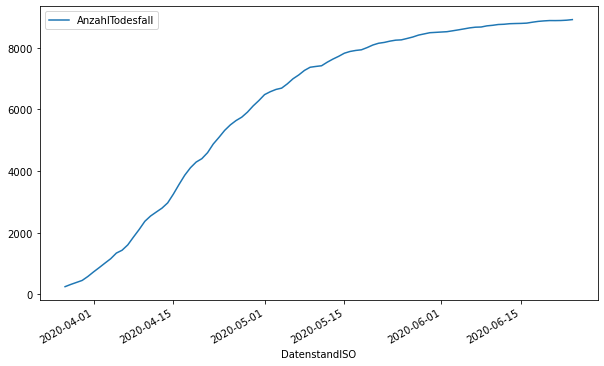

In [30]:
ard.plot()

## Comparison with ECDC-Data

In [31]:
# load ecdc data
ecdc = pd.read_csv("../../data-truth/ECDC/truth_ECDC-Cumulative Deaths_Germany.csv")

ecdc = ecdc[['date', 'value']]

# use datetime index for plot
ecdc.date = pd.to_datetime(ecdc.date)
ecdc.set_index('date', inplace=True)

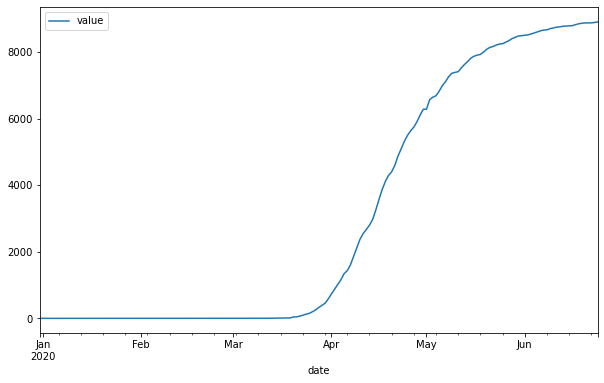

In [32]:
ecdc.plot()

To compare both timeseries we join them in one dataframe and plot them together.

In [33]:
# join both dataframes
df_compare = ecdc.join(ard, how='left')

df_compare.columns = ['ECDC', 'ARD']

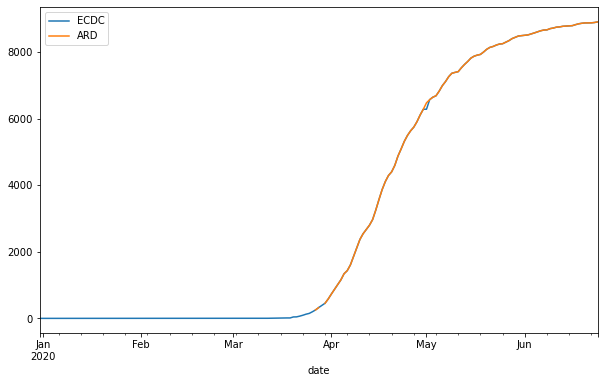

In [34]:
df_compare.plot()

In [35]:
# save as .csv
df_compare.to_csv("comparison_ard-ecdc.csv")

In the plot the timeseries look pretty much the same, let's check for each date if there are any differences.

In [36]:
# rows with different entries
df_compare[df_compare.ARD != df_compare.ECDC]

,ECDC,ARD
date,,
2019-12-31,0,NaN
2020-01-01,0,NaN
2020-01-02,0,NaN
2020-01-03,0,NaN
2020-01-04,0,NaN
...,...,...
2020-03-25,149,NaN
2020-03-26,198,NaN
2020-03-29,389,NaN


The ard data starts later and there is a difference at two dates (2020-05-01 and 2020-06-20).

# Aggregation on state level (Bundesländer)

Now that we have verified the data on a national level, we aggregate the data for each state seperately.

### Aggregation

In [37]:
# compute the sum for each date within each state
df_agg = df[df.NeuerTodesfall >= 0].groupby(['DatenstandISO', 'Bundesland'])['AnzahlTodesfall'].sum().reset_index()

In [38]:
df_agg

,DatenstandISO,Bundesland,AnzahlTodesfall
0,2020-03-27,Baden-Württemberg,70
1,2020-03-27,Bayern,55
2,2020-03-27,Berlin,8
3,2020-03-27,Brandenburg,1
4,2020-03-27,Bremen,1
...,...,...,...
1417,2020-06-24,Saarland,169
1418,2020-06-24,Sachsen,222
1419,2020-06-24,Sachsen-Anhalt,58
1420,2020-06-24,Schleswig-Holstein,152


### Add FIPS region codes

We add the corresponding region codes for each state given by https://en.wikipedia.org/wiki/List_of_FIPS_region_codes_(G–I)#GM:_Germany.

In [39]:
state_names = ['Baden-Württemberg', 'Bayern', 'Bremen', 'Hamburg', 'Hessen', 'Niedersachsen', 'Nordrhein-Westfalen', 'Rheinland-Pfalz',
'Saarland', 'Schleswig-Holstein', 'Brandenburg', 'Mecklenburg-Vorpommern', 'Sachsen', 'Sachsen-Anhalt', 'Thüringen', 'Berlin']

gm = ['GM0' + str(i) for i in range(1, 10)] + ['GM' + str(i) for i in range(10, 17)] 

fips_codes = pd.DataFrame({'Bundesland':state_names, 'location':gm})

In [40]:
fips_codes

,Bundesland,location
0,Baden-Württemberg,GM01
1,Bayern,GM02
2,Bremen,GM03
3,Hamburg,GM04
4,Hessen,GM05
5,Niedersachsen,GM06
6,Nordrhein-Westfalen,GM07
7,Rheinland-Pfalz,GM08
8,Saarland,GM09
9,Schleswig-Holstein,GM10


In [41]:
# add fips codes to dataframe with aggregated data
df_agg = df_agg.merge(fips_codes, left_on='Bundesland', right_on='Bundesland')

### Change location_name to English names

In [42]:
fips_english = pd.read_csv('../../template/base_germany.csv')

In [43]:
fips_english.head()

,V1,V2
0,GM01,Baden-Württemberg State
1,GM02,Free State of Bavaria
2,GM03,Free Hanseatic City of Bremen
3,GM04,Free Hanseatic City of Hamburg
4,GM05,Hesse State


In [44]:
df_agg = df_agg.merge(fips_english, left_on='location', right_on='V1')

### Rename columns and sort by date and location

In [45]:
df_agg = df_agg.rename(columns={'DatenstandISO': 'date', 'AnzahlTodesfall': 'value', 'V2':'location_name'})[
    ['date', 'location', 'location_name', 'value']].sort_values(['date', 'location']).reset_index(drop=True)

In [46]:
df_agg

,date,location,location_name,value
0,2020-03-27,GM01,Baden-Württemberg State,70
1,2020-03-27,GM02,Free State of Bavaria,55
2,2020-03-27,GM03,Free Hanseatic City of Bremen,1
3,2020-03-27,GM04,Free Hanseatic City of Hamburg,2
4,2020-03-27,GM05,Hesse State,7
...,...,...,...,...
1417,2020-06-24,GM12,Mecklenburg-Western Pomerania State,20
1418,2020-06-24,GM13,Free State of Saxony,222
1419,2020-06-24,GM14,Sachsen-Anhalt State,58
1420,2020-06-24,GM15,Free State of Thüringia,178


## Plot cumulative deaths by state

In [47]:
df_agg.date = pd.to_datetime(df_agg.date)

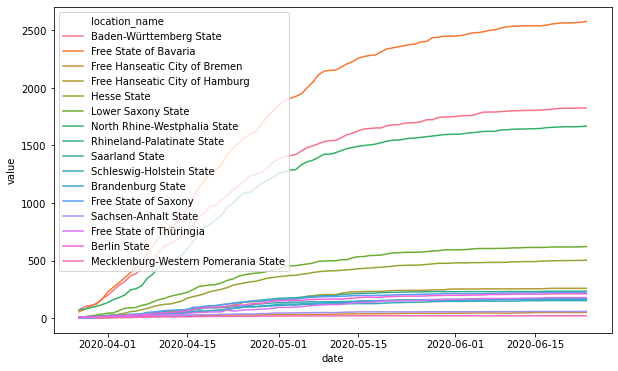

In [48]:
sb.lineplot(data=df_agg, x='date', y='value', hue='location_name')

### Add total count for Germany

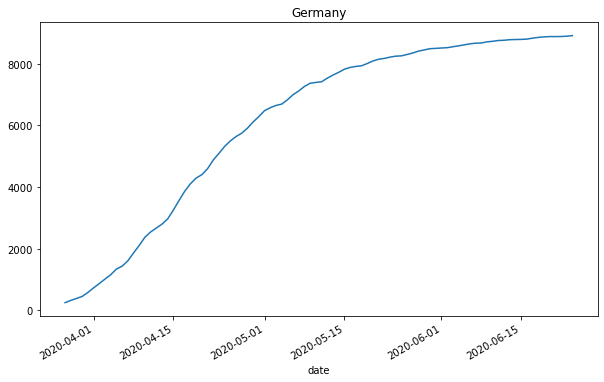

In [49]:
df_agg.groupby('date')['value'].sum().plot(title='Germany')

In [50]:
df_germany = df_agg.groupby('date')['value'].sum().reset_index()

In [51]:
df_germany['location'] = 'GM'
df_germany['location_name'] = 'Germany'

In [52]:
df_germany.head()

,date,value,location,location_name
0,2020-03-27,253,GM,Germany
1,2020-03-28,325,GM,Germany
2,2020-03-30,455,GM,Germany
3,2020-03-31,583,GM,Germany
4,2020-04-01,732,GM,Germany


In [53]:
# add data for Germany to dataframe with states
df_cum = pd.concat([df_agg, df_germany]).sort_values(['date', 'location']).reset_index(drop=True)

In [54]:
df_cum.head()

,date,location,location_name,value
0,2020-03-27,GM,Germany,253
1,2020-03-27,GM01,Baden-Württemberg State,70
2,2020-03-27,GM02,Free State of Bavaria,55
3,2020-03-27,GM03,Free Hanseatic City of Bremen,1
4,2020-03-27,GM04,Free Hanseatic City of Hamburg,2


In [55]:
df_cum.date = pd.to_datetime(df_cum.date)

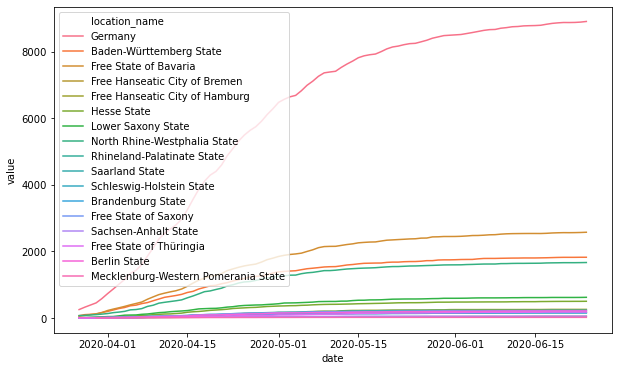

In [56]:
sb.lineplot(data=df_cum, x='date', y='value', hue='location_name')

### Export Cum. Deaths

In [57]:
latest_date = str(df_cum.date.iloc[-1].date()) # latest date in data for the filename

df_cum.to_csv('truth_cum_deaths_' + latest_date + '.csv', index=False)

# Incidence

We compute the incident deaths as the difference to the previous day.

In [58]:
df_inc = df_cum.copy()

In [59]:
df_inc.value = df_inc.groupby(['location'])['value'].diff()
df_inc.dropna(inplace=True)

In [60]:
df_inc.head()

,date,location,location_name,value
16,2020-03-28,GM,Germany,72.0
17,2020-03-28,GM01,Baden-Württemberg State,31.0
18,2020-03-28,GM02,Free State of Bavaria,22.0
19,2020-03-28,GM03,Free Hanseatic City of Bremen,1.0
20,2020-03-28,GM04,Free Hanseatic City of Hamburg,0.0


Sanity check for Germany:

In [61]:
# cumulative
df_cum[df_cum.location=='GM'].head()

,date,location,location_name,value
0,2020-03-27,GM,Germany,253
16,2020-03-28,GM,Germany,325
32,2020-03-30,GM,Germany,455
49,2020-03-31,GM,Germany,583
66,2020-04-01,GM,Germany,732


In [62]:
# incidence
df_inc[df_inc.location=='GM'].head()

,date,location,location_name,value
16,2020-03-28,GM,Germany,72.0
32,2020-03-30,GM,Germany,130.0
49,2020-03-31,GM,Germany,128.0
66,2020-04-01,GM,Germany,149.0
83,2020-04-02,GM,Germany,140.0


## Plot incident deaths for Germany

In [63]:
df_inc.date = pd.to_datetime(df_inc.date)
df_inc.set_index('date', inplace=True)

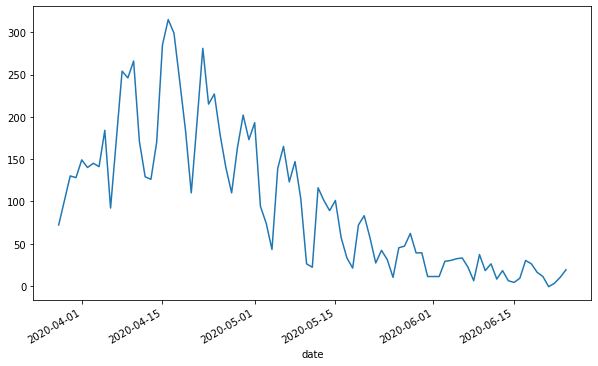

In [64]:
df_inc[df_inc.location == 'GM']['value'].plot()

## Plot incident deaths for Germany

In [66]:
df_inc.reset_index(inplace=True)

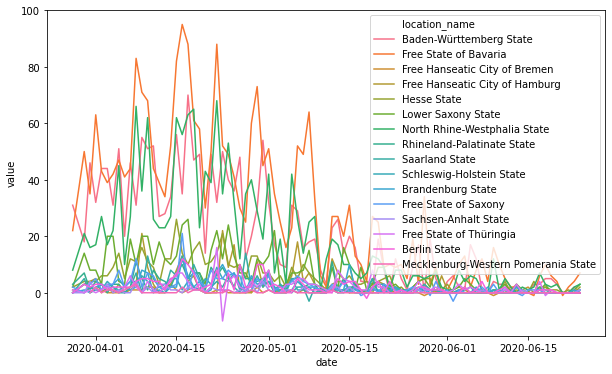

In [67]:
sb.lineplot(data=df_inc[df_inc.location != 'GM'], x='date', y='value', hue='location_name')

### Export Inc. Deaths

In [68]:
latest_date = str(df_inc.date.iloc[-1].date()) # latest date in data for the filename

df_inc.to_csv('truth_inc_deaths_' + latest_date + '.csv', index=False)